In [1]:
!pip install wfdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 135.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [26]:
import wfdb
from scipy.signal import resample
import numpy as np
from tqdm import tqdm
from wfdb import processing
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, classification_report, confusion_matrix
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#Loading Datasets (MIT-BIH and Supraventricular Arrhythmia Dataset)

# Load record number 100
signals_bih, fields_bih = wfdb.rdsamp('101', sampto=1000, pn_dir='mitdb') #loads the ecg signal values - sample 101, from second 0 to second 2.87. 1000/360 = 2.87
# Load 5 seconds of data (5 * 128 = 640 samples)
signals_sup, fields_sup = wfdb.rdsamp('802', sampto=640, pn_dir='svdb')  # "svdb" = supraventricular arrhythmia dataset

# Load annotations (beat labels)
annotation_bih = wfdb.rdann('101', 'atr', pn_dir='mitdb') #read annotation(label for sample 101)
annotation_sup = wfdb.rdann('802', 'atr', pn_dir = 'svdb') #read annotation label for sample 802 for sup dataset

print(signals_bih.shape)  # (1000, 2)
print(annotation_bih.sample[:10])  # positions of first 10 beats
print(annotation_bih.symbol[:10])  # their labels (like 'N', 'V', 'A', etc.)

print(signals_sup.shape)  # (1000, 2)
print(annotation_sup.sample[:10])  # positions of first 10 beats
print(annotation_sup.symbol[:10])  # their labels (like 'N', 'V', 'A', etc.)

#signals is a numpy array, fields is a dictionary
# fields contains
# fs: The sampling frequency of the record.
# units: The units for each channel.
# sig_name: The signal name for each channel.
# comments: Any comments written in the header.
print()
print("MIT-BIH freq:", fields_bih['fs'])
print("SVDB freq:", fields_sup['fs'])
print("The MIT-BIH dataset has a sample of 360 per second per channel while SVDB dataset has a sample of 128 per second.")



(1000, 2)
[   7   83  396  711 1032 1368 1712 2036 2349 2662]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
(640, 2)
[ 105  234  362  490  619  747  868  987 1107 1229]
['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']

MIT-BIH freq: 360
SVDB freq: 128
The MIT-BIH dataset has a sample of 360 per second per channel while SVDB dataset has a sample of 128 per second.


In [3]:
#Resampling SVDB to 360 per second

# Function to resample svdb record
def resample_svdb_record(rec_name, target_fs=360):
    record = wfdb.rdrecord(rec_name, pn_dir='svdb') #Reading record
    ann = wfdb.rdann(rec_name, 'atr', pn_dir='svdb') #Getting annotation for record

    #Resampling signals and annotations (all channels)
    signals_resampled, ann_resampled = processing.resample_multichan(
    xs=record.p_signal,
    ann=ann,
    fs=record.fs,
    fs_target=fs_target
)
    return signals_resampled, ann_resampled

#Function to save resampled record to folder
def save_resampled_record(signals, annotations, record_name, folder='combined_db', fs=360):
 #Save the signal
  wfdb.wrsamp(
        record_name=record_name,
        fs=fs,
        units=['mV'] * signals.shape[1],
        sig_name=[f'ECG{i+1}' for i in range(signals.shape[1])],
        p_signal=signals,
        write_dir= folder
    )

  #Save annotations
  wfdb.wrann(
            record_name=record_name,
            extension='atr',
            fs=fs,
            sample=annotations.sample,
            symbol=annotations.symbol,
            write_dir = folder
        )

#Loading record liats of both databases
record_list_sup = wfdb.get_record_list('svdb')
record_list_mit = wfdb.get_record_list('mitdb')
fs_target = 360
folder = 'combined_db'
os.makedirs(folder, exist_ok=True)


# Resample and save all SVDB records
print("Resampling and saving SVDB records")
for i, rec_name in enumerate(tqdm(record_list_sup)):
    try:
        signals_resampled, ann_resampled = resample_svdb_record(rec_name, fs_target)
        save_resampled_record(signals_resampled, ann_resampled, record_name=f'svdb_360_{i:02d}',folder=folder)
    except Exception as e:
        print(f"Error processing record {rec_name}: {e}")


Resampling and saving SVDB records


100%|██████████| 78/78 [09:28<00:00,  7.29s/it]


In [4]:
print("Copying MIT-BIH records into combined_db folder (same format as original)")
wfdb.dl_database('mitdb', dl_dir=folder)

print("MIT-BIH records successfully downloaded into combined_db")


Copying MIT-BIH records into combined_db folder (same format as original)
Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 20

In [5]:
#Segment beats in samples

def get_beat_boundaries(r_peaks, signal_length):
    """
    Estimate start and end indices of each beat using R-peaks.
    Each beat goes from midpoint between previous and current R,
    to midpoint between current and next R.
    """
    boundaries = []
    for i in range(1, len(r_peaks)-1):
        start = int((r_peaks[i-1] + r_peaks[i]) / 2)
        end = int((r_peaks[i] + r_peaks[i+1]) / 2)
        if start >= 0 and end <= signal_length:
            boundaries.append((start, end))
    return boundaries



combined_db_path = '/content/combined_db'     # folder with all records (.dat, .hea, .atr)
output_folder = '/content/segmented_beats'    # folder where segmented beats will be stored

# Record list
# this finds all the records (e.g. 100, 101, svdb_360_00, etc.)
record_list = sorted(list(set([f.split('.')[0] for f in os.listdir(combined_db_path) if f.endswith('.dat')])))

os.makedirs(output_folder, exist_ok=True)
all_beats = []
all_labels = []

# Process every record
for rec_name in tqdm(record_list, desc="Segmenting beats"):
    record_path = os.path.join(combined_db_path, rec_name)

    try:
        # Read ECG signal and annotation
        record = wfdb.rdrecord(record_path)
        ann = wfdb.rdann(record_path, 'atr')

        signal = record.p_signal[:, 0]   # use first ECG channel
        fs = record.fs
        r_peaks = ann.sample  #gives the indices of consecutive r_peaks

        # Find beat boundaries
        boundaries = get_beat_boundaries(r_peaks, len(signal))
        labels = ann.symbol[1:len(boundaries)+1]

        # Segment beats and labels
        beats = [signal[start:end] for (start, end) in boundaries]

        # Clip to same length
        min_len = min(len(beats), len(labels))
        beats = beats[:min_len]
        labels = labels[:min_len]

        # Append to combined dataset
        all_beats.extend(beats)
        all_labels.extend(labels)

    except Exception as e:
        print(f"Error processing {rec_name}: {e}")


# Convert to numpy arrays
X = np.array([np.array(b) for b in all_beats], dtype=object)  # variable-length beats
y = np.array(all_labels)

print(f"\nTotal beats: {len(X)}")
print(f"Unique labels: {set(y)}")


Segmenting beats: 100%|██████████| 126/126 [00:05<00:00, 24.71it/s]



Total beats: 300272
Unique labels: {np.str_('|'), np.str_('R'), np.str_('e'), np.str_('V'), np.str_('a'), np.str_('+'), np.str_('L'), np.str_('f'), np.str_('N'), np.str_('A'), np.str_(']'), np.str_('J'), np.str_('['), np.str_('Q'), np.str_('!'), np.str_('~'), np.str_('"'), np.str_('B'), np.str_('j'), np.str_('E'), np.str_('F'), np.str_('x'), np.str_('/'), np.str_('S')}


In [6]:
#Pre-processing
#Resampling each beat to be 360 points

target_len = 360
X = np.array([resample(b, target_len) for b in all_beats])
le = LabelEncoder()  # initialize encoder
Y = le.fit_transform(all_labels) #converts beat labels (symbols) into numeric class IDs.

X, Y = shuffle(X, Y, random_state=42)

# Remove empty or invalid beats (zero or NaN)
clean_beats = []
clean_labels = []
for b, l in zip(X, Y):
    if len(b) == 0:  # empty beat
        continue
    if np.any(np.isnan(b)) or np.all(b == 0):  # invalid beat
        continue
    clean_beats.append(b)
    clean_labels.append(l)

X = np.array(clean_beats)
Y = np.array(clean_labels)



In [7]:
#Remove rare classes
unique, counts = np.unique(Y, return_counts=True)
rare_classes = unique[counts < 2]
mask = ~np.isin(Y, rare_classes)
X = X[mask]
Y = Y[mask]


#Normalize
# Normalize each beat to range [-1, 1]
X = np.array([b / np.max(np.abs(b)) if np.max(np.abs(b)) > 0 else b for b in X], dtype=np.float32)
X = np.clip(X, -1.0, 1.0)

Y = Y.astype(np.int32)


In [8]:
#Splitting data into training, validation and testing sets
# First split: Train + Temp (which we’ll later split into validation and test)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

# Second split: Validation + Test
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp
)

# Reshape for CNN (adding the channel dimension)
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print("Data split complete:")
print(f"Training set:   {X_train.shape}, labels: {Y_train.shape}")
print(f"Validation set: {X_val.shape}, labels: {Y_val.shape}")
print(f"Testing set:    {X_test.shape}, labels: {Y_test.shape}")


Data split complete:
Training set:   (210189, 360, 1), labels: (210189,)
Validation set: (45041, 360, 1), labels: (45041,)
Testing set:    (45041, 360, 1), labels: (45041,)


In [9]:

num_classes = len(np.unique(Y))

optimizer = Adam(learning_rate=1e-4, clipnorm = 1.0, epsilon=1e-8)


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train),
    y=Y_train
)
class_weights_dict = dict(enumerate(class_weights))

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_val   = le.transform(Y_val)
Y_test  = le.transform(Y_test)

num_classes = len(le.classes_)  # one hot encode y
Y_train_cat = to_categorical(Y_train, num_classes=num_classes)
Y_val_cat   = to_categorical(Y_val, num_classes=num_classes)

model = Sequential([
    Conv1D(32, 7, activation='relu', input_shape=(360, 1)),
    MaxPooling1D(2),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # num_classes = number of unique labels
])



model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 354, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 177, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 173, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 86, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5504)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       704,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 718,167 (2.74 MB)

 Trainable params: 718,167 (2.74 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#Training

start_time = time.perf_counter()
history = model.fit(
    X_train, Y_train_cat,
    validation_data=(X_val, Y_val_cat),
    epochs=30,
    batch_size=32,
    class_weight=class_weights_dict,
    verbose=1
)
end_time = time.perf_counter()


Epoch 1/30
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.4804 - loss: 3.3209 - val_accuracy: 0.7191 - val_loss: 0.8935
Epoch 2/30
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.6625 - loss: 2.8305 - val_accuracy: 0.7667 - val_loss: 0.7791
Epoch 3/30
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.7320 - loss: 2.7223 - val_accuracy: 0.8068 - val_loss: 0.6402
Epoch 4/30
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.7709 - loss: 2.7818 - val_accuracy: 0.8403 - val_loss: 0.5601
Epoch 5/30
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.7934 - loss: 2.4309 - val_accuracy: 0.8590 - val_loss: 0.4883
Epoch 6/30
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8109 - loss: 1.6172 - val_accuracy: 0.8696 - val_loss: 0.4619
Epoch 7/30
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8239 - loss: 2.2244 - val_accuracy: 0.8664 - val_loss: 0.4626
Epoch 8/30
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8313 - loss: 2

In [34]:
#Testing and Evaluation

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute metrics
accuracy = accuracy_score(Y_test, y_pred_classes)
precision = precision_score(Y_test, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(Y_test, y_pred_classes, average='weighted', zero_division=1)
f1 = f1_score(Y_test, y_pred_classes, average='weighted', zero_division=1)
elapsed_time = end_time - start_time


print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Training time: {elapsed_time/60:.4f} minutes")


1408/1408 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Accuracy:  0.9171
Precision: 0.9407
Recall:    0.9171
F1-score:  0.9249
Training time: 13.3244 minutes


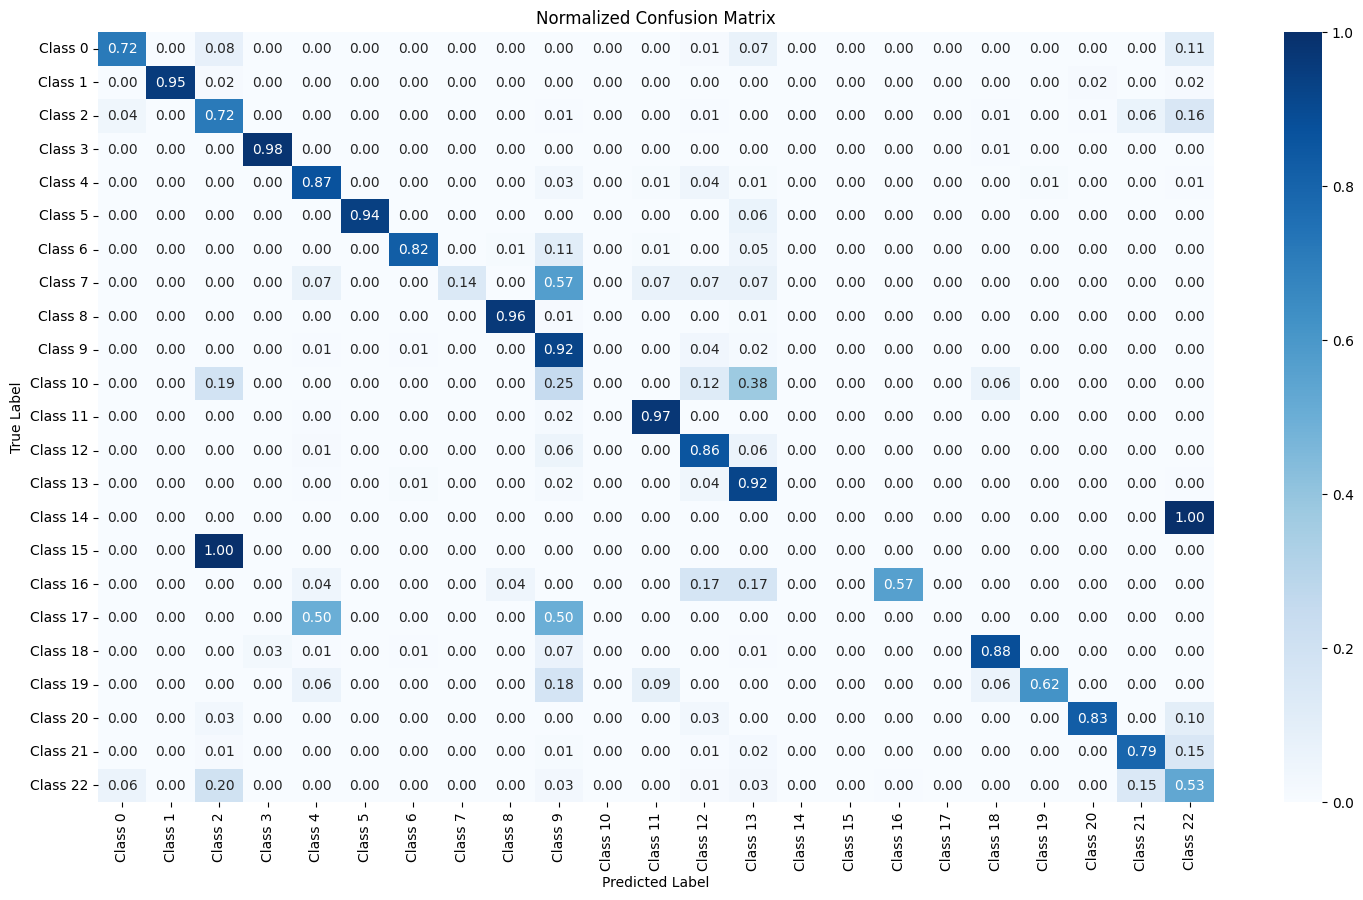

In [39]:
#Normalized Confusion Matrix
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(Y_test, y_pred_classes)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize by row

plt.figure(figsize=(18, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f"Class {i}" for i in range(cm.shape[1])],
            yticklabels=[f"Class {i}" for i in range(cm.shape[0])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()



In [37]:
report = classification_report(Y_test, y_pred_classes)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.72      0.65        71
           1       1.00      0.95      0.98        65
           2       0.59      0.72      0.65       187
           3       0.99      0.98      0.99      1053
           4       0.52      0.87      0.65       382
           5       0.88      0.94      0.91        16
           6       0.31      0.82      0.45       124
           7       0.06      0.14      0.09        14
           8       0.96      0.96      0.96      1211
           9       0.99      0.92      0.96     35582
          10       0.00      0.00      0.00        16
          11       0.90      0.97      0.93      1089
          12       0.53      0.86      0.66      1828
          13       0.76      0.92      0.83      2560
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.46      0.57      0.51        23
   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
model.save("model.h5")